# Ray Path Calculation and Visualization

## Getting Started

This notebook demonstrates the numerical computation and visualization of seismic ray paths in two- and three-dimensional heterogeneous velocity models using the Runge–Kutta method.

The numerical implementations are provided in `Eikonal2d.py` and `Eikonal3d.py`.

The ray tracing algorithm provides a numerical solution to the Eikonal equation:

$$
(\nabla \tau)^2 = \frac{1}{c^2(\mathbf{x})},
$$

where $\tau$ is the travel time and $c(\mathbf{x})$ is the spatially varying seismic velocity.

Both 2D and 3D ray tracing schemes are implemented.  
For simplicity and clarity, this notebook focuses on the **2D implementation** for visualization, including examples such as:
- test models,
- shadow zones,
- and triplication phenomena.

The **3D implementation** is used only for basic test cases and demonstration purposes.

### Requirements
- Python 3.10
- NumPy
- Matplotlib

### Usage

#### File structure
Ensure the following files are located in the same directory as this notebook:
- `Eikonal2d.py`
- `Eikonal3d.py`


#### 2D ray tracing (Eikonal2d)

**Initialize the model**
```python
M = Eikonal2d(v0, ds=5, max_step=50000)
```
**Compute a single ray path**
```python
rayx, rayz, rayt = M.Raypath(x0, z0, toa, multi=0)
```

**Parameter description**

- v0(x, z) : 2D velocity function

- ds : integration step size

- max_step : maximum number of integration steps

- x0, z0 : source position

- toa : take-off angle (radians)

- multi: enable surface multiple reflections (`1` = on, `0` = off)

#### 3D ray tracing (Eikonal3d)

**Initialize the model**
```python
M = Eikonal3d(v, ds=1, max_step=500000)
```
**Compute a single ray path**
```python
rayx, rayy, rayz, rayt = M.Raypath(x0, y0, z0, toa, multi=0)
```

**Parameter description**

- v(x, y, z) : 3D velocity function

- ds : integration step size

- max_step : maximum number of integration steps

- x0, y0, z0 : source position

- toa : take-off angle (inclination, radians)

- theta : azimuth angle (radians)

- multi: enable surface multiple reflections (`1` = on, `0` = off)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import os
os.makedirs("images", exist_ok=True)
from Eikonal2d import Eikonal2d
from Eikonal3d import Eikonal3d
from DrawRay import DrawRay

# Solve 2D Eikonal Equation
## Test board
### Generate the Test Velocity Models

#### Linearly Layered Velocity Model
$v(z) = v_0 + \alpha z$

This test model has an analytical solution.  
It is used to validate the correctness and accuracy of the ray tracing algorithm by comparing numerical results with theoretical solutions.

#### Piecewise Velocity Model
$v=\left\{\begin{matrix}
  v_1, & z\le z_0 \\
  v_2, & z>z_0
\end{matrix}\right.$

A two-layer velocity model with a sharp interface is constructed using a piecewise-defined function.  
Direct ray tracing in this model may lead to numerical instability when computing ray paths and travel times, due to the discontinuity in velocity and its gradient.

#### Sigmoid Velocity Model
To avoid numerical issues associated with sharp velocity discontinuities, a smooth approximation of a step function is adopted.  
The velocity model is defined using a sigmoid function, the interface depth is controlled by dz:

$$v(z) = v_2 + \frac{v_1 - v_2}{1 + e^{(z - z_0)/d z}},$$


which provides a continuous and differentiable transition between layers while preserving the essential physical behavior.


In [6]:
# linearly Layered velocity model
def v0(x,z):
    return 2000+0.5*z

# piecewise velocity model
def v11(x, z):
    return np.piecewise(z, [z <= 2000, z > 2000], [1000, 2000])

# sigmoid velocity model
def v12(x, z):
    v1 = 1000
    v2 = 2000
    z0 = 2000
    dz = 5
    return v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))

def v121(x, z):
    v1 = 1000
    v2 = 2000
    z0 = 2000
    dz = 50
    return v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))


#### Visualize the Test Velocity Models

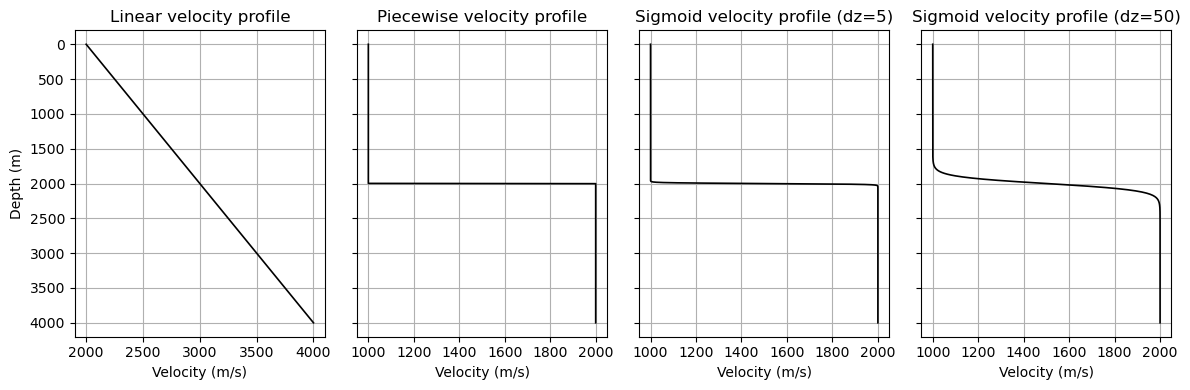

In [7]:
# draw the velocity profile
depth = np.linspace(0, 4000, 1000)
models = [
    (v0,  "Linear velocity profile"),
    (v11, "Piecewise velocity profile"),
    (v12, "Sigmoid velocity profile (dz=5)"),
    (v121, "Sigmoid velocity profile (dz=50)")
]

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

for ax, (vfun, title) in zip(axes, models):
    v_profile = vfun(0, depth)
    ax.plot(v_profile, depth, 'k', linewidth=1.2)
    ax.set_title(title)
    ax.set_xlabel('Velocity (m/s)')
    ax.grid(True)

axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()

plt.tight_layout()
plt.savefig("images/Test_velocity_profile.png",dpi=600)
plt.show()


### Show the Result of the Linearly Layered Velocity Model ($v(z) = v_0 + \alpha z$) Using `Eikonal2d`  
####

In this section, we compare the **numerical ray-tracing results** with the **analytical solution** for a linearly Layered velocity model to verify the correctness of the code.

#### Initial Conditions and Geometrical Relations

The ray parameter (Snell constant) is defined as

$$
p = \frac{\sin\theta_0}{v_0}
$$

According to Snell’s law,

$$
\frac{\sin\theta}{v(z)} = p
\quad \Rightarrow \quad
\sin\theta = p \, v(z)
$$

#### 

From ray geometry,

$$
\sin\theta = \frac{dx}{\sqrt{dx^2 + dz^2}}, \qquad
\cos\theta = \frac{dz}{\sqrt{dx^2 + dz^2}}, \qquad
v(z)\, dt = \sqrt{dx^2 + dz^2}
$$

---

#### Ray Equations

Combining the above relations, the ray trajectory satisfies

$$
\frac{dz}{dx}
=
\sqrt{
\frac{1}{p^2 (v_0 + \alpha z)^2} - 1
}
$$

The travel-time increment can be written as

$$
dt
=
\frac{dz}
{(v_0 + \alpha z)\sqrt{1 - p^2 (v_0 + \alpha z)^2}}
$$
---

#### Analytical Solution

By solving the above two integral expressions, an analytical solution is obtained for the Linearly layered velocity medium, which is used to validate the numerical results.

The horizontal distance is

$$
X
=
\frac{2v_0}{\alpha\tan\theta_0}
$$

and the corresponding travel time is

$$
T
=
\frac{1}{\alpha}
\ln
\left(
\frac{1 + \cos\theta_0}{1 - \cos\theta_0}
\right)
$$

#### Comparison between analytical and numerical solutions for a linear velocity gradient model


C:\Users\20369\AppData\Local\Temp\ipykernel_22256\2688311137.py:7: RuntimeWarning: divide by zero encountered in divide
  T_analy=np.log((1+np.cos(toa))/(1-np.cos(toa)))/alp


 TOA (deg) |    X_num (m) |    X_ana (m) |   RelErr_X |  T_num (s) |  T_ana (s) |   RelErr_T
--------------------------------------------------------------------------------------------
    -60.00 |     -4621.57 |     -4618.80 |  -6.00e-04 |      2.199 |      2.197 |   7.29e-04
    -45.00 |     -8002.99 |     -8000.00 |  -3.74e-04 |      3.528 |      3.525 |   6.01e-04
    -30.00 |    -13858.82 |    -13856.41 |  -1.75e-04 |      5.270 |      5.268 |   4.60e-04
    -15.00 |    -29857.54 |    -29856.41 |  -3.81e-05 |      8.113 |      8.110 |   2.71e-04
     15.00 |     29857.54 |     29856.41 |   3.81e-05 |      8.113 |      8.110 |   2.71e-04
     30.00 |     13858.82 |     13856.41 |   1.75e-04 |      5.270 |      5.268 |   4.60e-04
     45.00 |      8002.99 |      8000.00 |   3.74e-04 |      3.528 |      3.525 |   6.01e-04
     60.00 |      4621.57 |      4618.80 |   6.00e-04 |      2.199 |      2.197 |   7.29e-04


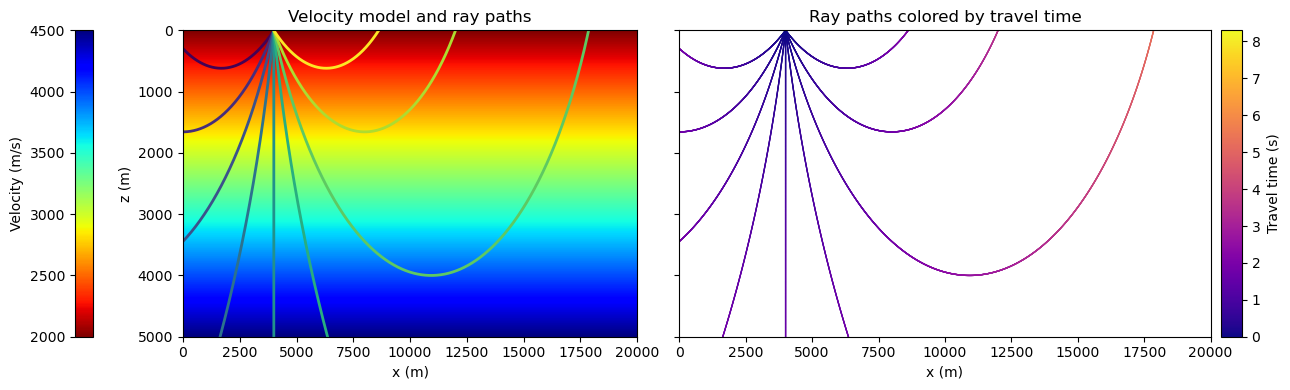

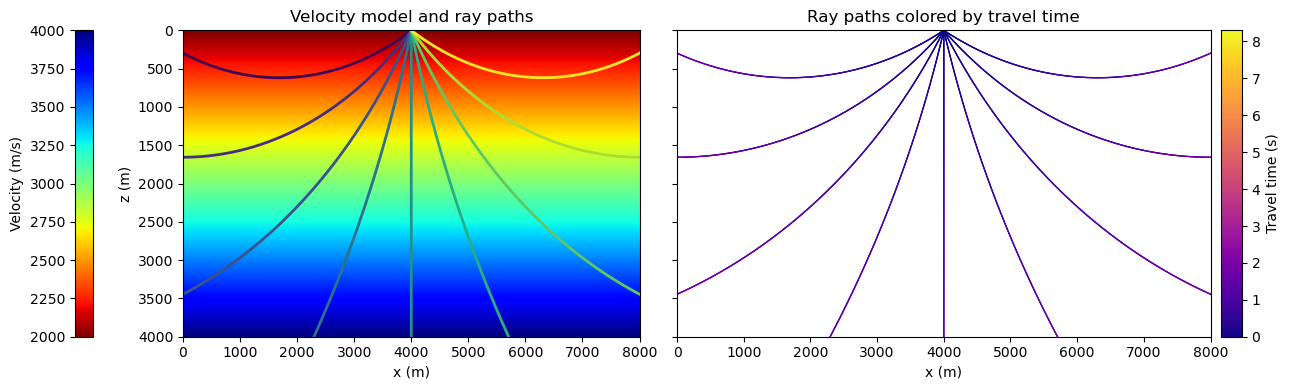

In [22]:
# analytical solutions
u0,alp=2000,0.5
# d=np.pi/100
d=np.pi/12
toa=np.arange(-np.pi/3,np.pi/3+d,d) # take off angle
X_analy=2*u0/np.tan(toa)/alp
T_analy=np.log((1+np.cos(toa))/(1-np.cos(toa)))/alp

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v0,ds=5,max_step=50000)
#####################################################################################

print("="*92)
print(f"{'TOA (deg)':>10} | {'X_num (m)':>12} | {'X_ana (m)':>12} | {'RelErr_X':>10} "
      f"| {'T_num (s)':>10} | {'T_ana (s)':>10} | {'RelErr_T':>10}")
print("-"*92)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all,rayz_all,rayt_all=[],[],[]
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(4000, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

    if ii != round(len(toa)/2):
        toa_deg = toa[ii] / np.pi * 180
        X_num = rayx[-1] - 4000
        X_ana = X_analy[ii]
        T_num = rayt[-1]
        T_ana = T_analy[ii]

        err_X = abs(X_ana - X_num) / X_ana
        err_T = abs(T_ana - T_num) / T_ana

        print(f"{toa_deg:10.2f} | "
              f"{X_num:12.2f} | {X_ana:12.2f} | {err_X:10.2e} | "
              f"{T_num:10.3f} | {T_ana:10.3f} | {err_T:10.2e}")

print("="*92)

DrawRay(
    xmin=0,
    xmax=20000,
    zmin=0,
    zmax=5000,
    v0=v0,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="LinearTestBoard"
)

DrawRay(
    xmin=0,
    xmax=8000,
    zmin=0,
    zmax=4000,
    v0=v0,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="LinearTestBoard2"
)

### Reflection Phenomenon

The velocity model `v11` represents the true double-layer structure. However, this code cannot handle such an unanalytical solution. 

In our calculation, $p_x$ is obtained using

$$
\frac{dp_x}{ds} = \frac{\partial}{\partial x} \left( \frac{1}{v(x,z)} \right),
$$

where the derivative $\frac{\partial}{\partial x} \left( \frac{1}{v(x,z)} \right)$ is computed using a finite difference with a small increment $\delta$. Since $p_x$ is advanced along a step size $ds$, the relationship between $ds$ and $\delta$ affects the accuracy. Specifically:

<img src="differenceregion.png" width="500" />
- If $ds \gg \delta$, the ray does not properly sense the interface and its direction changes very little.
- If $ds \ll \delta$, the finite-difference approximation becomes inaccurate and introduces large numerical errors.

Moreover, the derivative at the interface is not well-defined, which further complicates the calculation.

To overcome these issues, we use the sigmoid-based models `v12` and `v121` to approximate the double-layer velocity function. These models provide a continuous derivative, allowing the numerical solution to handle the interface smoothly.


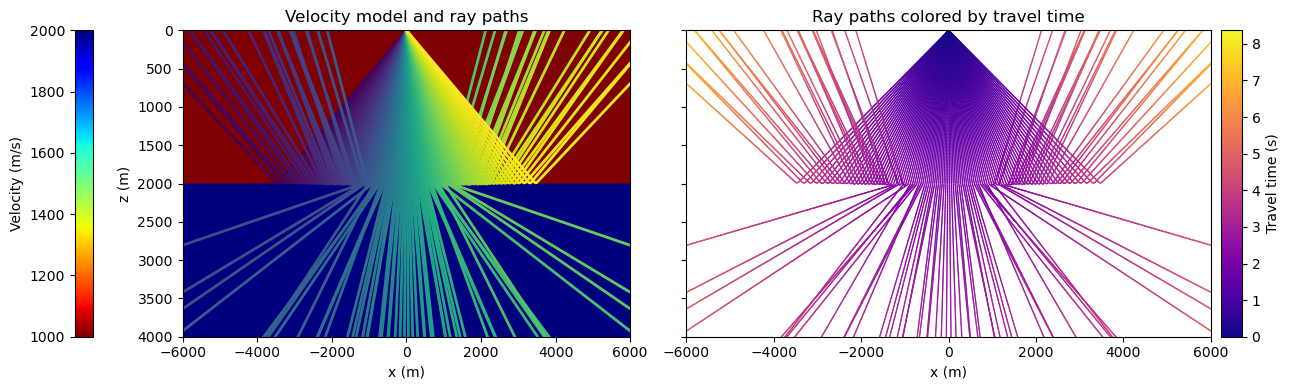

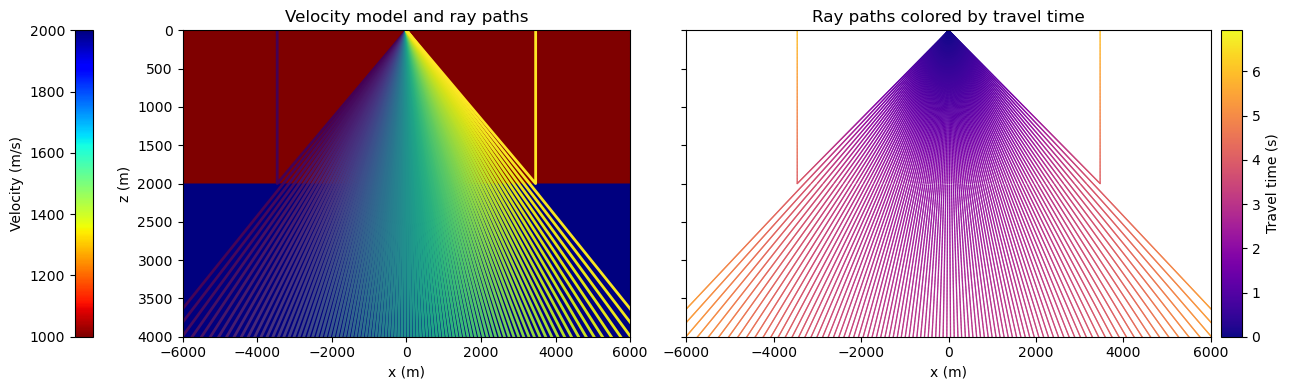

C:\Users\20369\AppData\Local\Temp\ipykernel_22256\1254127065.py:15: RuntimeWarning: overflow encountered in exp
  return v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))


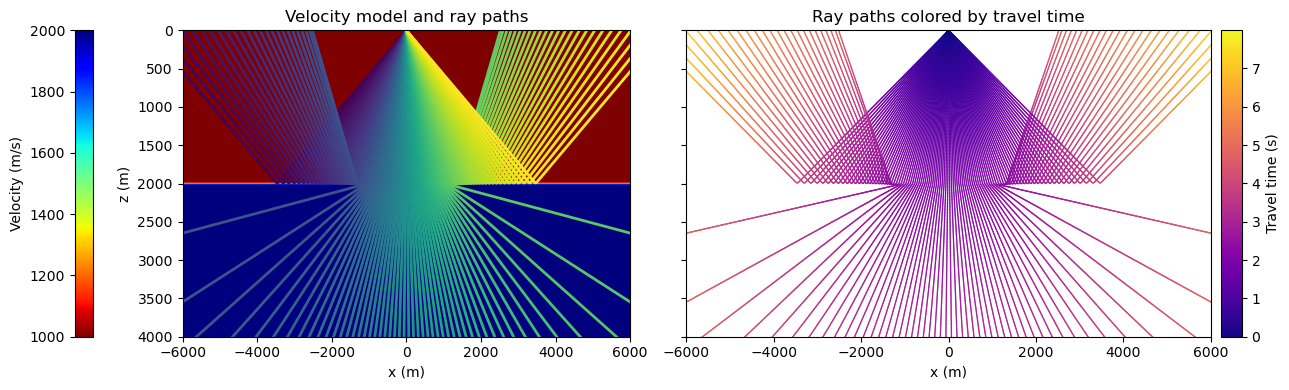

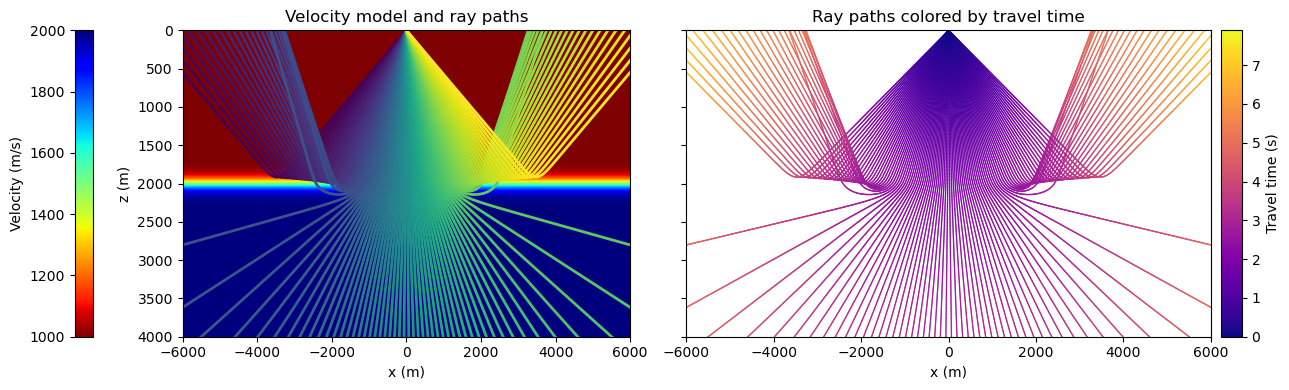

In [9]:
toa=np.linspace(-np.pi/3,np.pi/3,100)

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v11,ds=10,max_step=1000,delta=20)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=-6000,
    xmax=6000,
    zmin=0,
    zmax=4000,
    v0=v11,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Piecewise_double_layer(delta=20)"
)

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v11,ds=10,max_step=1000,delta=1e-5)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=-6000,
    xmax=6000,
    zmin=0,
    zmax=4000,
    v0=v11,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Piecewise_double_layer(delta=1e-5)"
)

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v12,ds=10,max_step=1000)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=-6000,
    xmax=6000,
    zmin=0,
    zmax=4000,
    v0=v12,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Sigmoid(dz=5)"
)

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v121,ds=10,max_step=1000)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=-6000,
    xmax=6000,
    zmin=0,
    zmax=4000,
    v0=v121,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Sigmoid(dz=50)"
)

#### Multi-reflected ray paths
To calculate multi-reflected ray paths, the `parameter` must be set to `1`.
When `multi = 1`, the ray tracing algorithm allows rays to continue propagating even after interacting with the free surface, enabling the simulation of multiple reflections.

This behavior is implemented through the following logical condition:
```python
if multi==0:
    if path_z[-1]<0:
        break
```

To correctly model free-surface reflection, the surface boundary must be properly treated.
In the real world, the surface corresponds to air, where the seismic wave velocity is approximately zero. However, directly setting the surface velocity to zero leads to numerical and physical inconsistencies in the Eikonal formulation. According to Snell’s law,

$$\frac{\sin\theta}{v}=\frac{\sin\theta_s}{v_s}$$

as $\theta\approx 0$, the incidence angle $\theta$ tends toward zero, which implies vertical propagation rather than reflection.

Moreover, free-surface reflection is fundamentally governed by the wave transport equation and boundary conditions, rather than the Eikonal equation itself. Although $\theta_s=0$ is a mathematically valid solution, all incident wave energy should be reflected at the free surface.

To overcome this limitation within the Eikonal-based ray-tracing framework, we artificially assign an extremely large velocity at the surface. This treatment effectively enforces ray reflection and allows free-surface reflections to be generated manually within the numerical scheme.


C:\Users\20369\AppData\Local\Temp\ipykernel_22256\2141890942.py:10: RuntimeWarning: overflow encountered in exp
  S = 1.0 / (1.0 + np.exp((z - z_s) / dz_s))


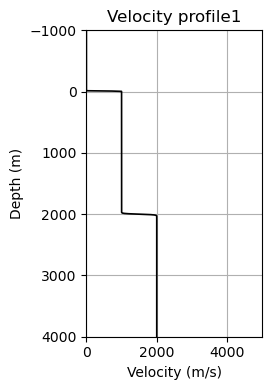

C:\Users\20369\AppData\Local\Temp\ipykernel_22256\2141890942.py:23: RuntimeWarning: overflow encountered in exp
  S = 1.0 / (1.0 + np.exp((z - z_s) / dz_s))


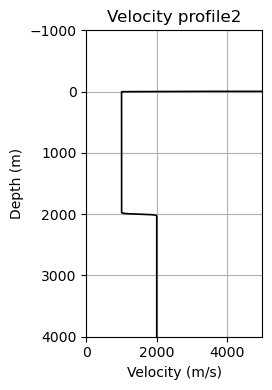

C:\Users\20369\AppData\Local\Temp\ipykernel_22256\2141890942.py:6: RuntimeWarning: overflow encountered in exp
  v_base = v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))
c:\Users\20369\Documents\SUSTech\05Programming\Computational Methods\project\submitted\Eikonal2d.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5*(1/self.v(x+delta,z)-1/self.v(x-delta,z))/delta
c:\Users\20369\Documents\SUSTech\05Programming\Computational Methods\project\submitted\Eikonal2d.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  return 0.5*(1/self.v(x+delta,z)-1/self.v(x-delta,z))/delta
c:\Users\20369\Documents\SUSTech\05Programming\Computational Methods\project\submitted\Eikonal2d.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5*(1/self.v(x,z+delta)-1/self.v(x,z-delta))/delta
c:\Users\20369\Documents\SUSTech\05Programming\Computational Methods\project\submitted\Eikonal2d.py:17: RuntimeWarning: invalid value encountered in scalar s

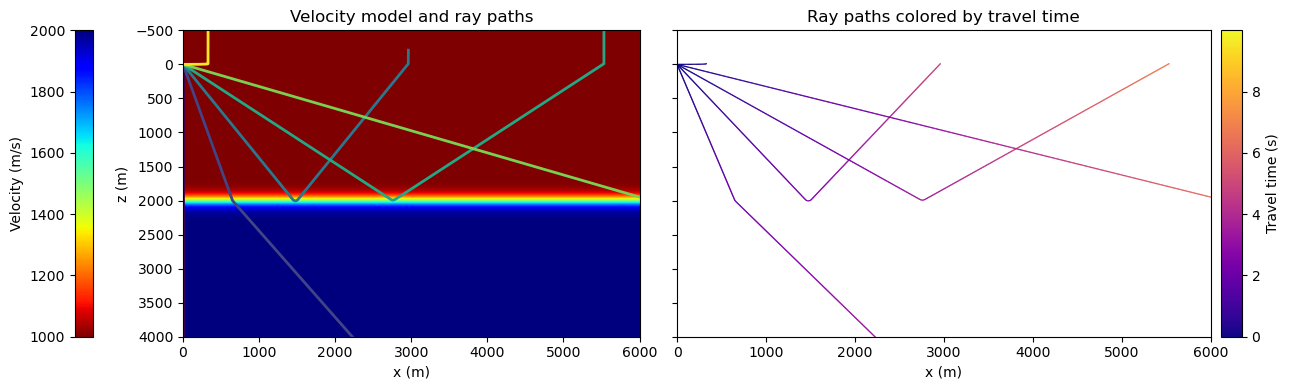

C:\Users\20369\AppData\Local\Temp\ipykernel_22256\2141890942.py:19: RuntimeWarning: overflow encountered in exp
  v_base = v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))


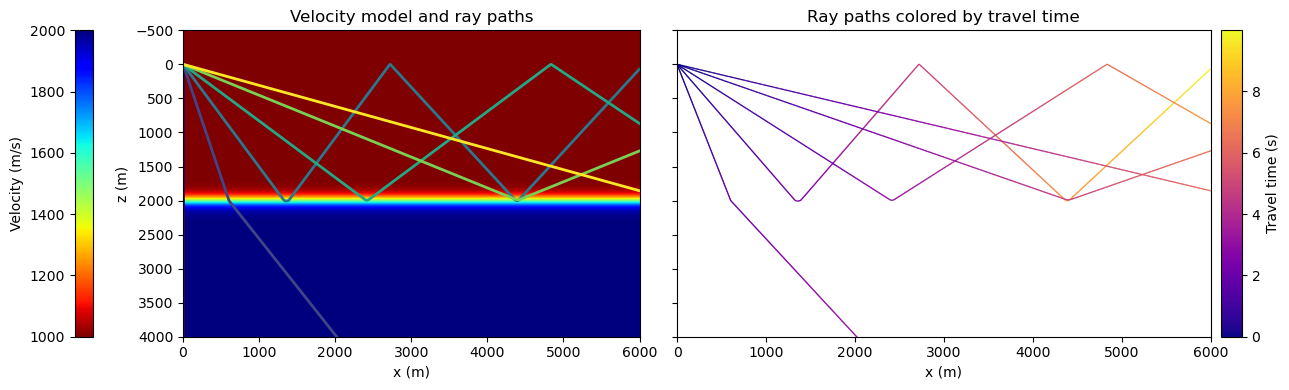

In [10]:
def vm1(x, z):
    v1 = 1000
    v2 = 2000
    z0 = 2000
    dz = 5
    v_base = v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))

    z_s = -10.0 
    dz_s = 1.0 
    S = 1.0 / (1.0 + np.exp((z - z_s) / dz_s))
    v_surface = 0.0
    return (1 - S) * v_base + S * v_surface

def vm2(x, z):
    v1 = 1000
    v2 = 2000
    z0 = 2000
    dz = 5
    v_base = v2 + (v1 - v2) / (1 + np.exp((z - z0) / dz))

    z_s = -10.0 
    dz_s = 1.0 
    S = 1.0 / (1.0 + np.exp((z - z_s) / dz_s))
    v_surface = 1000000.0
    return (1 - S) * v_base + S * v_surface

depth = np.linspace(-1000, 4000, 1000)
u=vm1(0,depth)
plt.figure(figsize=(3,4))
plt.plot(u,depth,'k-',linewidth=1.2)
plt.axis([0,5000,max(depth),min(depth)])
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.title("Velocity profile1")
plt.tight_layout()
plt.grid()
plt.show()
u=vm2(0,depth)
plt.figure(figsize=(3,4))
plt.plot(u,depth,'k-',linewidth=1.2)
plt.axis([0,5000,max(depth),min(depth)])
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.title("Velocity profile2")
plt.tight_layout()
plt.grid()
plt.show()

toa=np.linspace(0,np.pi/2,6)
#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(vm1,ds=10,max_step=1000)
############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii],multi=1)
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=0,
    xmax=6000,
    zmin=-500,
    zmax=4000,
    v0=v121,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="multi-reflection1"
)

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(vm2,ds=10,max_step=1000)
############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii],multi=1)
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=0,
    xmax=6000,
    zmin=-500,
    zmax=4000,
    v0=v121,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="multi-reflection2)"
)

# Shadow Zone

If the velocity increases with depth at first but decreases later, a shadow zone can appear where seismic waves do not arrive.  
We use `Eikonal2d` to demonstrate this effect.

## Generate the velocity model `v_shadow`

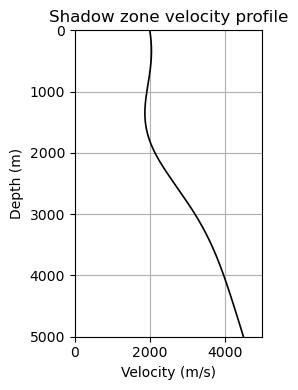

In [11]:
# shodow zone velocity function
def v_shadow(x,z ):
    v_bg = 2000 + 0.5 * z
    dv   = 200
    zc   = 1250
    dz   = 1300
    return v_bg - 0.003*z*dv * np.exp(-((z - zc) / dz) ** 2)
toa=np.linspace(np.pi/6,np.pi/2,100)

# def v_shadow(x,z ):
#     v_bg = 2000 + 0.3 * z
#     dv   = 200
#     zc   = 1800
#     dz   = 1300
#     dv1   = 1000
#     zc1   = 4000
#     dz1   = 1300
#     return v_bg - 0.003*z*dv * np.exp(-((z - zc) / dz) ** 2)+0.3*1/(np.exp((z-zc)/dz)+1) -dv1 * np.exp(-((z - zc1) / dz1) ** 2)

depth=np.linspace(0,5000,1000)
v=v_shadow(0,depth)

plt.figure(figsize=(3,4))
plt.plot(v,depth,'k-',linewidth=1.2)
plt.axis([0,5000,max(depth),min(depth)])
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.title("Shadow zone velocity profile")
plt.tight_layout()
plt.grid()
plt.savefig("images/Shadow_zone_velocity_profile.png",dpi=600)
plt.show()

## Visualize ray paths and travel time versus epicentral distance

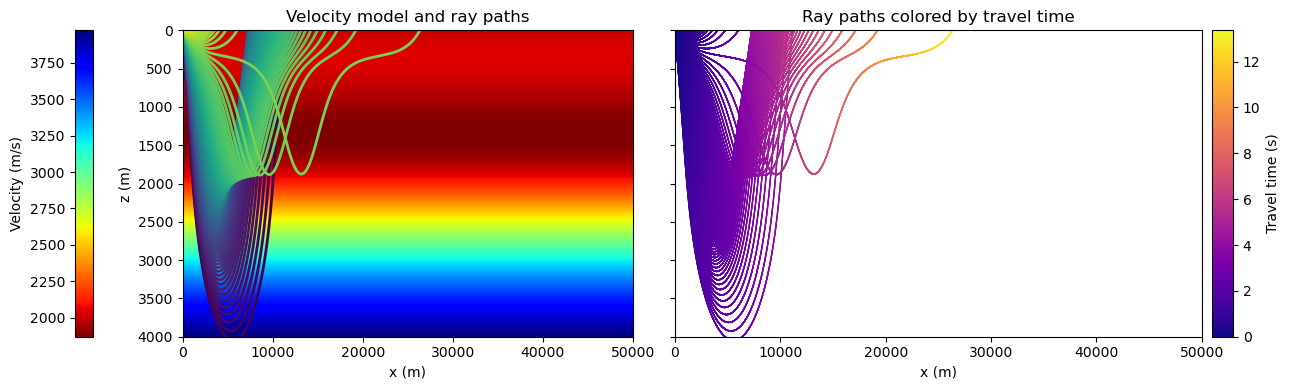

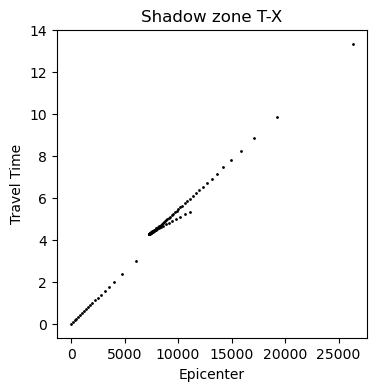

In [12]:
#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v_shadow,ds=5,max_step=50000)
# toa=np.linspace(np.pi/3,np.pi/2,100)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=0,
    xmax=50000,
    zmin=0,
    zmax=4000,
    v0=v_shadow,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Shadow_zone"
)

rayx_last = [x[-1] for x in rayx_all]
rayt_last = [t[-1] for t in rayt_all]
plt.figure(figsize=(4,4))
plt.scatter(rayx_last, rayt_last, s=1,color='black')
plt.xlabel("Epicenter")
plt.ylabel("Travel Time")
plt.title("Shadow zone T-X")
plt.savefig("images/Shadow_zone_XT,png",dpi=600)
plt.show()

# Triplication

**Triplication** refers to the phenomenon that **multiple seismic rays arrive at the same epicentral distance with different travel times**.

It occurs when the velocity increases with depth but the **velocity gradient changes strongly**.  
We use `Eikonal2d` to demonstrate this effect numerically.

## Generate the velocity model `v_triplication`

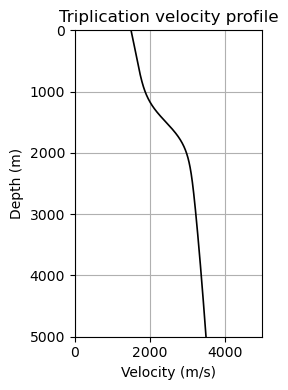

In [13]:
def v_triplication(x, z):
    V0 = 1500
    Vmax = 3000
    zc = 1500
    k = 0.005
    a1 = 500
    b1 = 0.0005
    slow = a1 * (1 - np.exp(-b1 * z))
    fast = (Vmax - V0 - slow.max()) / (1 + np.exp(-k * (z - zc)))
    V = V0 + slow + fast
    return V+0.1*z

depth = np.linspace(0, 5000, 1000)
v = v_triplication(0, depth)

plt.figure(figsize=(3,4))
plt.plot(v,depth,'k-',linewidth=1.2)
plt.axis([0,5000,max(depth),min(depth)])
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.title("Triplication velocity profile")
plt.tight_layout()
plt.grid()
plt.savefig("images/Triplication_velocity_profile.png",dpi=600)
plt.show()

## Visualize ray paths and travel time versus epicentral distance

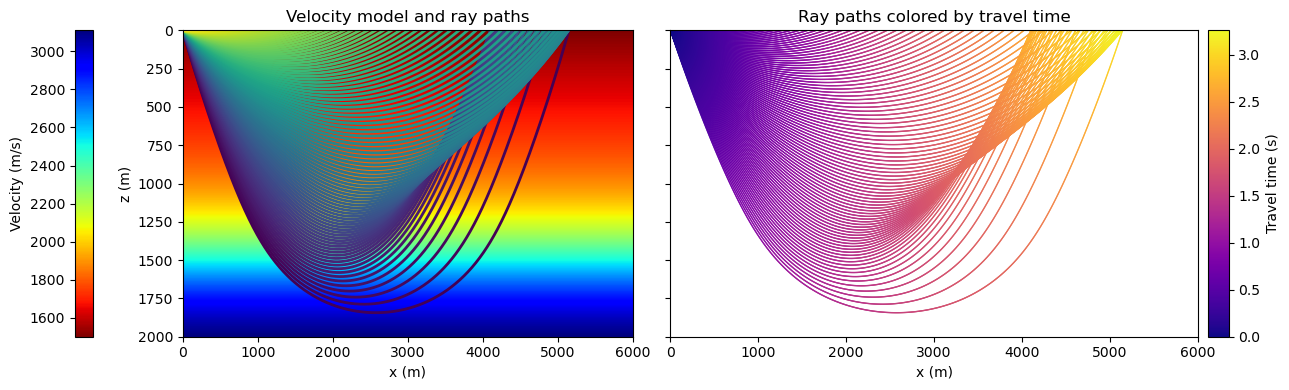

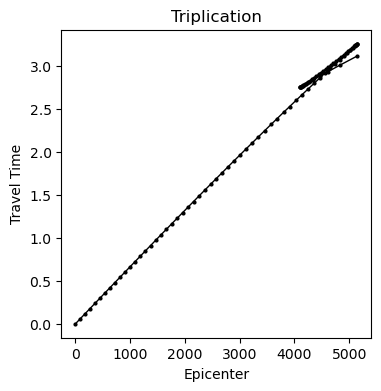

In [14]:
#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v_triplication,ds=5,max_step=5000)
toa=np.linspace(np.pi/6,np.pi/2,100)

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(0, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=0,
    xmax=6000,
    zmin=0,
    zmax=2000,
    v0=v_triplication,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Triplication"
)

rayx_last = [x[-1] for x in rayx_all]
rayt_last = [t[-1] for t in rayt_all]
plt.figure(figsize=(4,4))
plt.plot(rayx_last, rayt_last, marker='o', linestyle='-', color='black', markersize=2, linewidth=1)
plt.xlabel("Epicenter")
plt.ylabel("Travel Time")
plt.title("Triplication")
plt.savefig("images/Triplication_XT,png",dpi=600)
plt.show()


# Solve the Class Problem (case: 2D)

Based on the previous derivations and numerical experiments, we now solve the target problem with the following velocity model:

$$
v(x,z) = 1000 + 0.5\,z + 0.25\,x
$$

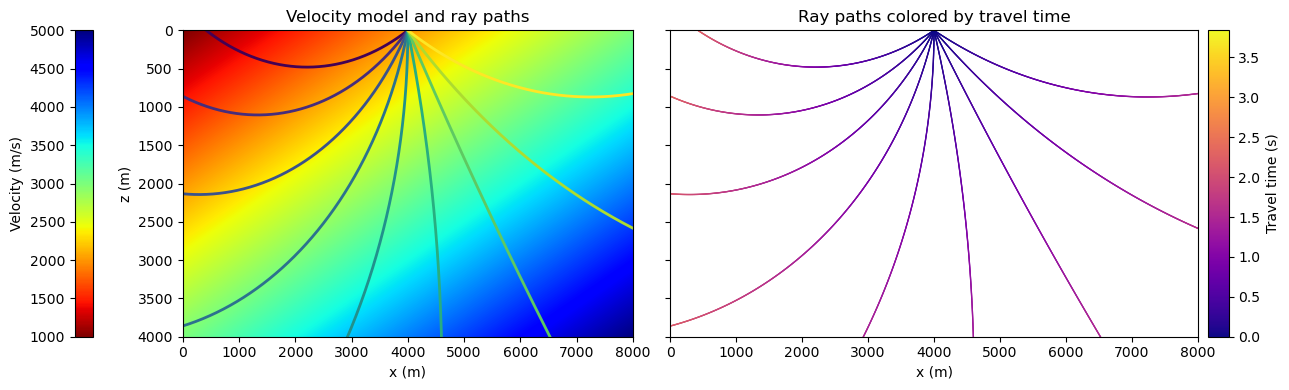

In [15]:
def v(x,z):
    return 1000+0.5*z+0.25*x

#####################  Use Eikonal2d to get numerical solutions  ####################
M=Eikonal2d(v,ds=5,max_step=1200)
d=np.pi/12
toa=np.arange(-np.pi/3,np.pi/3+d,d) # take off angle

############## Use Eikonal2d.Raypath to calculate the numerical solutions ###########
rayx_all, rayz_all, rayt_all = [], [], []
for ii in range(len(toa)):
    rayx, rayz, rayt = M.Raypath(4000, 0, toa[ii])
    rayx_all.append(rayx)
    rayz_all.append(rayz)
    rayt_all.append(rayt)
#####################################################################################

DrawRay(
    xmin=0,
    xmax=8000,
    zmin=0,
    zmax=4000,
    v0=v,
    rayx_all=rayx_all,
    rayz_all=rayz_all,
    rayt_all=rayt_all,
    fig_name="Answer"
)

# Solve the 3D Eikonal Equation

Following the 2D case, we use `Eikonal3d` to calculate the ray paths in a three-dimensional velocity model. Compared with the 2D formulation, two additional variables are introduced: the azimuth angle $\theta$ and the $y$ coordinate.

```python
M = Eikonal3d(v, ds=1, max_step=500000)
toa = np.pi / 3
azi = 12
rayx, rayy, rayz, rayt = M.Raypath(4000, 0, 0, toa, azi)
```

## Velocity Structure

e use the velocity sturucture provided in the ppt

$$v=1000+0.5*z+0/15*y+0.15*x$$

### Velocity profile Visualization

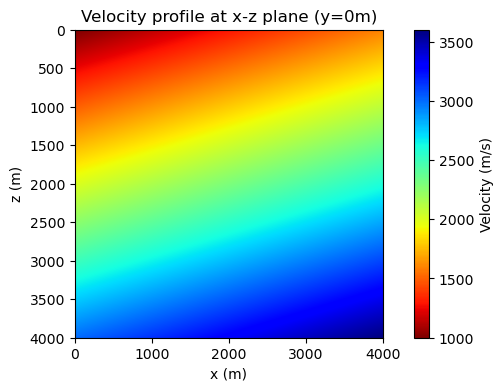

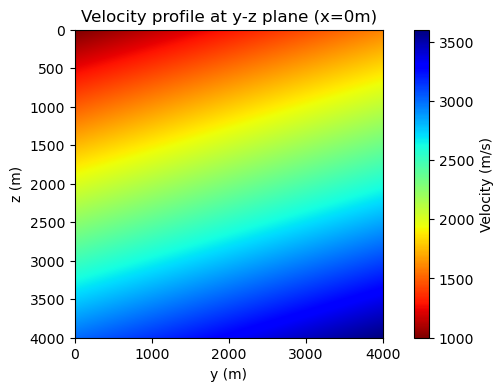

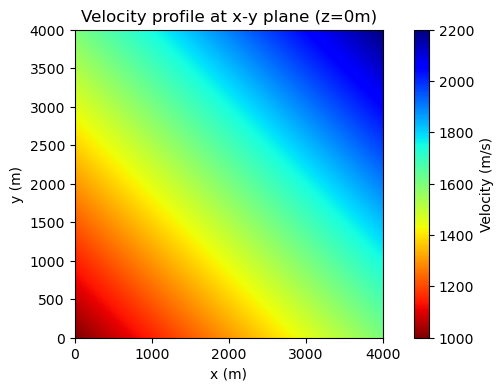

In [16]:
def v(x,y,z):
    return 1000+0.5*z+0.15*y+0.15*x

# draw the velocity structure at x-z plane
y=0
nx=1000
nz=1000
x=np.linspace(0,4000,nx)
z=np.linspace(0,4000,nz)
X,Z=np.meshgrid(x,z)
V=v(X,y,Z)

plt.figure(figsize=(8,4))
im=plt.imshow(
    V,
    extent=[x.min(),x.max(),z.max(),z.min()],
    cmap='jet_r'
)
plt.colorbar(im,label='Velocity (m/s)')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title(f'Velocity profile at x-z plane (y={y}m)')
plt.xlim(x.min(), x.max())
plt.ylim(z.max(), z.min())
plt.savefig(f'images/Velocity profile at x-z plane (y={y}m)')
plt.show()

## draw the velocity structure at y-z plane
x=0
ny=1000
nz=1000
y=np.linspace(0,4000,ny)
z=np.linspace(0,4000,nz)
Y,Z=np.meshgrid(y,z)
V=v(x,Y,Z)
plt.figure(figsize=(8,4))
im=plt.imshow(
    V,
    extent=[y.min(),y.max(),z.max(),z.min()],
    cmap='jet_r'
)
plt.colorbar(im,label='Velocity (m/s)')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.title(f'Velocity profile at y-z plane (x={x}m)')
plt.xlim(y.min(), y.max())
plt.ylim(z.max(), z.min())
plt.savefig(f'images/Velocity profile at y-z plane (x={x}m)')
plt.show()
# draw the velocity structure at x-y plane
z=0
nx=1000
ny=1000
x=np.linspace(0,4000,nx)
y=np.linspace(0,4000,ny)
X,Y=np.meshgrid(x,y)
V=v(X,Y,z)
plt.figure(figsize=(8,4))
im=plt.imshow(
    V,
    extent=[x.min(),x.max(),y.max(),y.min()],
    cmap='jet_r'
)
plt.colorbar(im,label='Velocity (m/s)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'Velocity profile at x-y plane (z={z}m)')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.savefig(f'images/Velocity profile at x-y plane (z={z}m)')
plt.show()



## Solve the 3D Ray Paths

### Ray Paths in a Half-Space Model




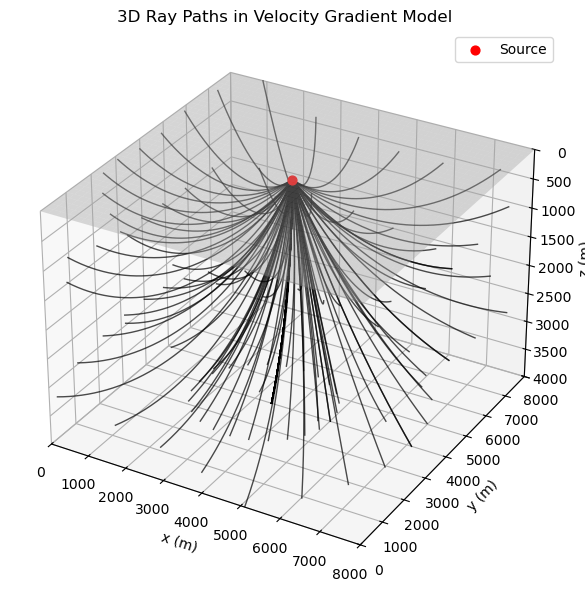

In [26]:

def clip_ray(rayx, rayy, rayz, rayt,
             xmin, xmax, ymin, ymax, zmin, zmax):
    mask = (
        (rayx >= xmin) & (rayx <= xmax) &
        (rayy >= ymin) & (rayy <= ymax) &
        (rayz >= zmin) & (rayz <= zmax)
    )
    return rayx[mask], rayy[mask], rayz[mask], rayt[mask]

#####################  Use Eikonal2d to get numerical solutions  ####################
M = Eikonal3d(v, ds=1, max_step=15000)
x0, y0, z0 = 4000, 4000, 0
toa_list = np.linspace(0, np.pi/3, 5)
azi_list = np.linspace(0, 2*np.pi, 25)
# -------------------------------
# Figure
# -------------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x0, y0, z0, color='r', s=40, label='Source')
xmin, xmax = 0, 8000
ymin, ymax = 0, 8000
zmin, zmax = 0, 4000


xs = np.linspace(xmin, xmax, 40)
ys = np.linspace(ymin, ymax, 40)
XS, YS = np.meshgrid(xs, ys)
ZS = np.zeros_like(XS)

ax.plot_surface(
    XS, YS, ZS,
    color='lightgray',
    alpha=0.4,
    linewidth=0
)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(zmin, zmax)

for toa in toa_list:
    for azi in azi_list:
############## Use Eikonal3d.Raypath to calculate the numerical solutions ###########
        rayx, rayy, rayz, rayt = M.Raypath(x0, y0, z0, toa, azi)
#####################################################################################
        rayx, rayy, rayz, rayt = clip_ray(
    rayx, rayy, rayz, rayt,
    xmin, xmax, ymin, ymax, zmin, zmax
)
        ax.plot(rayx, rayy, rayz, color='k', alpha=0.7, linewidth=1)



ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.invert_zaxis()
ax.set_title('3D Ray Paths in Velocity Gradient Model')
plt.legend()
plt.tight_layout()
plt.savefig('images/3draypath_surfacetime.png')
plt.show()


### Surface Travel-Time Field

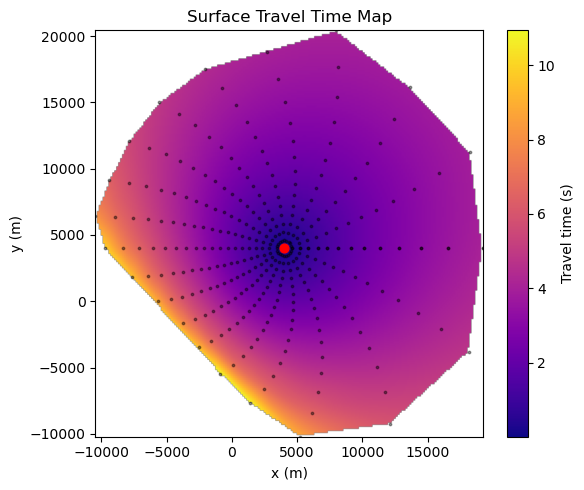

In [21]:
def v(x,y,z):
    return 1000+0.5*z+0.15*y+0.15*x

M = Eikonal3d(v, ds=10, max_step=2000)

x0, y0, z0 = 4000, 4000, 0
toa_list = np.linspace(0, np.pi/3, 5)
azi_list = np.linspace(0, 2*np.pi, 13)
toa_list = np.linspace(np.pi/12, np.pi/2, 21)
azi_list = np.linspace(0, 2*np.pi, 21)
xs_surf, ys_surf, ts_surf = [], [], []

for toa in toa_list:
    for azi in azi_list:
        rayx, rayy, rayz, rayt = M.Raypath(x0, y0, z0, toa, azi)
        z_end=rayz[-1]
        if z_end <= 0:
            xs_surf.append(rayx[-1])
            ys_surf.append(rayy[-1])
            ts_surf.append(rayt[-1])
            
from scipy.interpolate import griddata

xi = np.linspace(min(xs_surf), max(xs_surf), 200)
yi = np.linspace(min(ys_surf), max(ys_surf), 200)
XI, YI = np.meshgrid(xi, yi)

TI = griddata(
    (xs_surf, ys_surf),
    ts_surf,
    (XI, YI),
    method='cubic'
)
plt.figure(figsize=(6,5))

im = plt.imshow(
    TI,
    extent=[xi.min(), xi.max(), yi.min(), yi.max()],
    origin='lower',
    cmap='plasma',
    aspect='auto'
)

plt.scatter(xs_surf, ys_surf, c='k', s=3, alpha=0.4)
plt.scatter(4000,4000, color='r', s=40, label='Source')
plt.colorbar(im, label='Travel time (s)')

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Surface Travel Time Map')
plt.tight_layout()
plt.savefig('images/3draypath_surfacetime.png',dpi=600)
plt.show()
